# Model Development

### Imports

In [2]:
# Import libraries
import tensorflow as tf
from keras import layers, models
from keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'


KeyboardInterrupt: 

### Constants

In [18]:
# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
PLANT_VILLAGE_PATH = "data\PlantVillage"
CHANNELS = 3
EPOCH = 50


### TF Dataset

In [19]:
#TF Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PLANT_VILLAGE_PATH,
    shuffle = True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)



Found 2152 files belonging to 3 classes.


In [20]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [21]:
len(dataset)

68

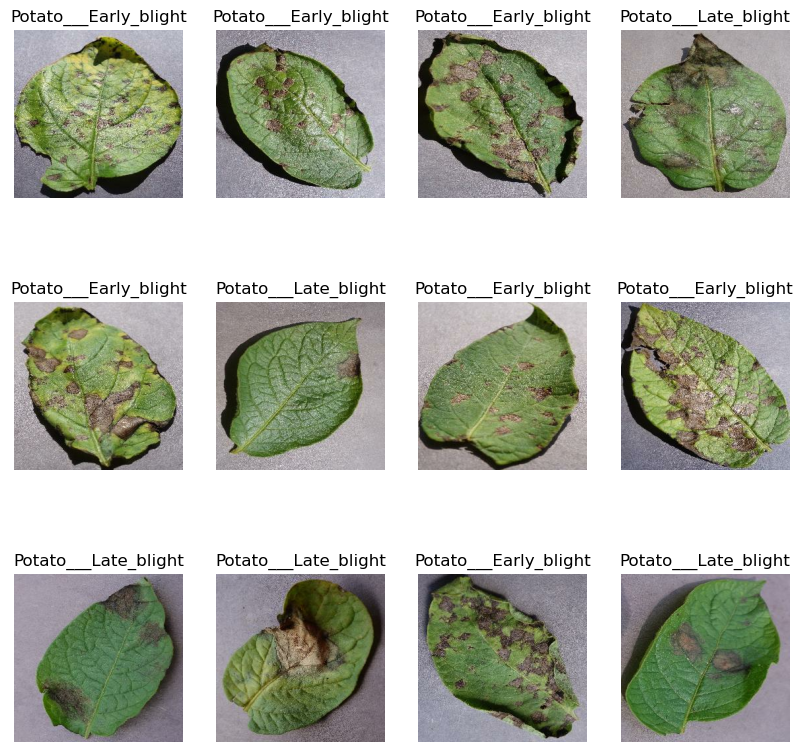

In [22]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1) 
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [23]:
len(dataset)

68

In [24]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [25]:
train_ds = dataset.take(54) # nice to know: arr[0:54]
len(train_ds)

54

In [26]:
test_ds = dataset.skip(54) # nice to know: arr[54:0]
len(test_ds)

14

### Splitting dataframe into train, validation and test

In [27]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
          
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    test_size = int(ds_size * test_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_size = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [28]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset) 

### Loading dataframes into cache for performance reason 

In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) # For perfomance
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) # For perfomance
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) # For perfomance

### Data augmentation

In [31]:
resize_and_scale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [32]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    #layers.RandomZoom(0.2)
])

### Model Development

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = tf.keras.Sequential([
    resize_and_scale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [42]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [43]:
history = model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 62s 957ms/step - loss: 0.8939 - accuracy: 0.5388 - val_loss: 0.7609 - val_accuracy: 0.7135
Epoch 2/50
54/54 [==============================] - 60s 1s/step - loss: 0.6264 - accuracy: 0.7274 - val_loss: 0.3980 - val_accuracy: 0.8229
Epoch 3/50
54/54 [==============================] - 58s 1s/step - loss: 0.3673 - accuracy: 0.8304 - val_loss: 0.3293 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 65s 1s/step - loss: 0.3302 - accuracy: 0.8663 - val_loss: 0.3868 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 57s 1s/step - loss: 0.2557 - accuracy: 0.8941 - val_loss: 0.3194 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 55s 1s/step - loss: 0.2109 - accuracy: 0.9155 - val_loss: 0.2923 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 53s 975ms/step - loss: 0.2143 - accuracy: 0.9230 - val_loss: 0.2434 - val_accuracy: 0.9062
Epoch 8/50
54/

In [44]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [51]:
model.save("model.h5")

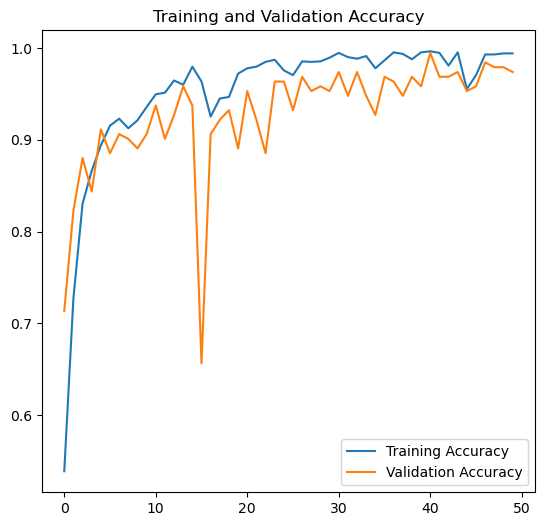

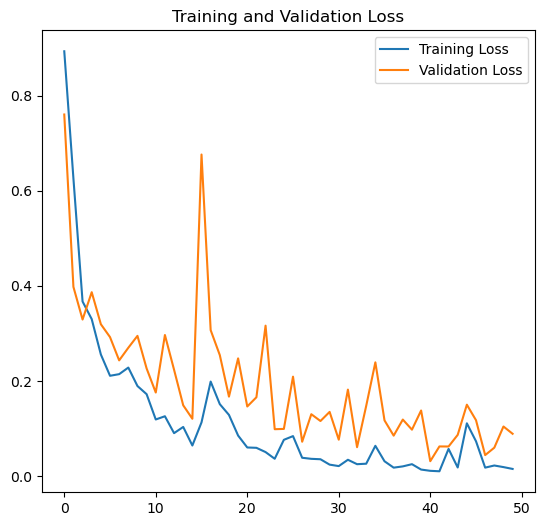

In [61]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2, 1)
plt.plot(range(EPOCH), acc, label="Training Accuracy")
plt.plot(range(EPOCH), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.figure(figsize=(14, 6))
plt.subplot(1,2, 2)
plt.plot(range(EPOCH), loss, label="Training Loss")
plt.plot(range(EPOCH), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()

Actual Label  Potato___Late_blight
1/1 [==============================] - 0s 268ms/step
Predicted Label:  Potato___Late_blight


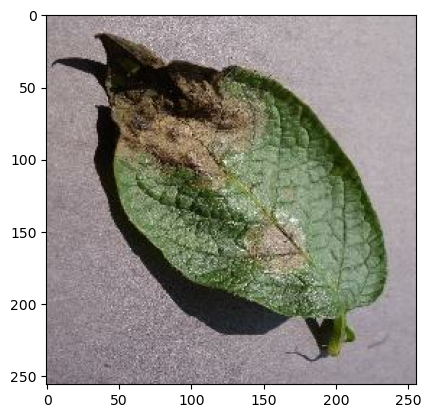

In [76]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    
    print("Actual Label ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])

### Prediction Function

In [94]:
def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Creates a batch
    
    predictions = model.predict(img_array)#
    
    predicted_class = class_names[np.argmax(batch_prediction[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence
    

1/1 [==============================] - 0s 47ms/step


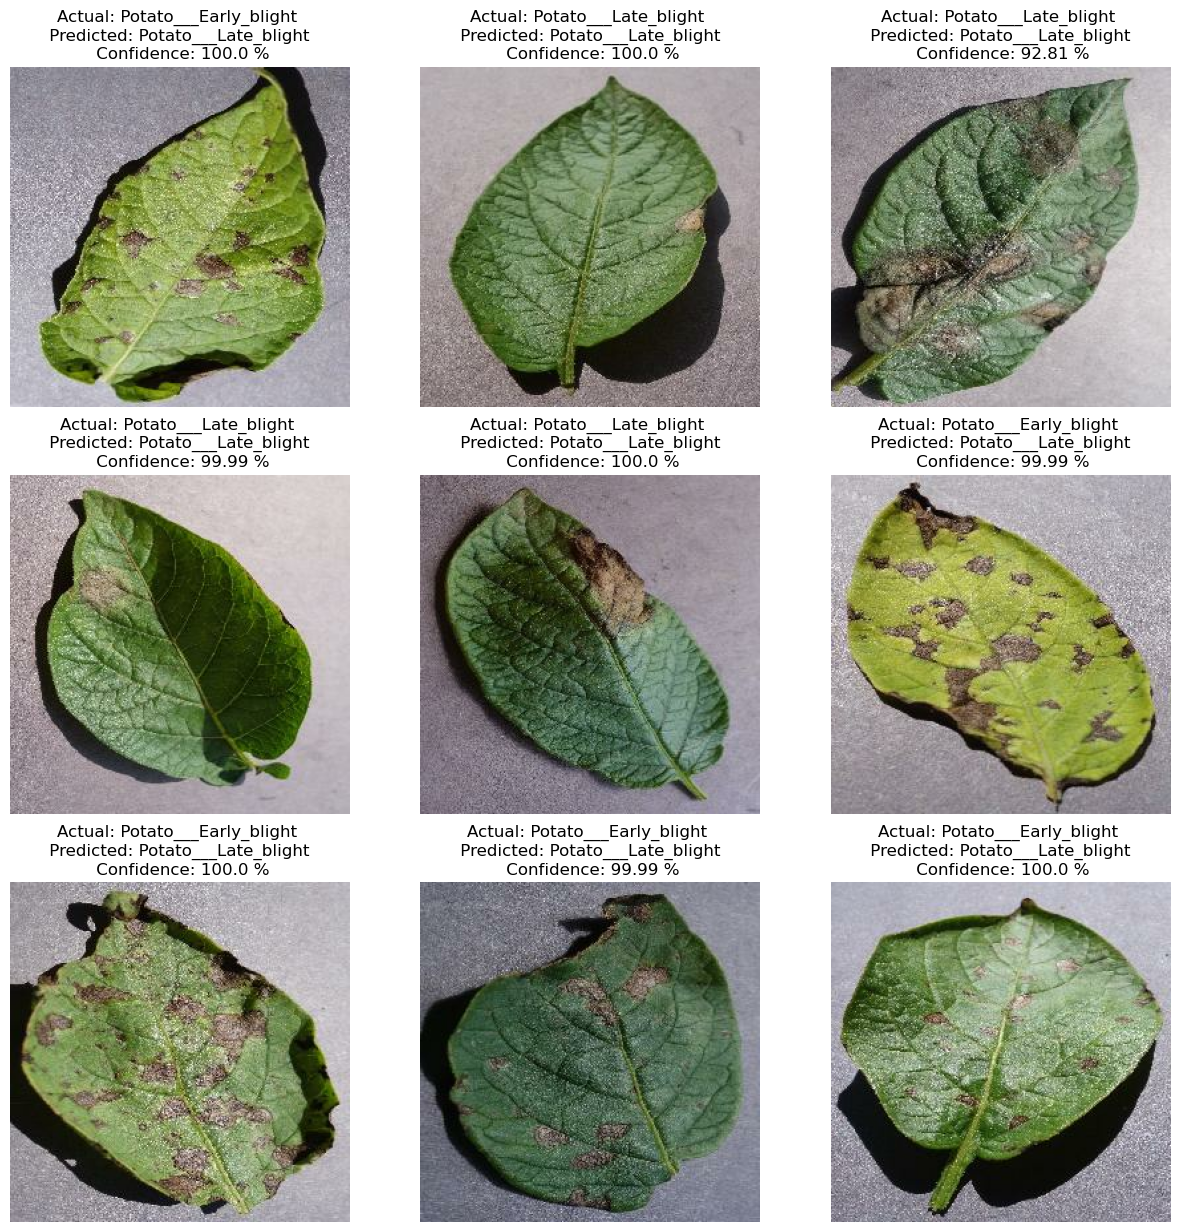

In [102]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
       
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence} %")
        
        plt.axis("off")

In [3]:
model_version = max([int(i) for i in os.listdir("model")]) + 1
model.save(f"model/v{model_version}")

NameError: name 'model' is not defined